<h2>Introduction</h2>
In this exercise you'll identify an initial set of features in the Ames dataset to develop using mutual information scores and interaction plots.

Run this cell to set everything up!

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression

# Load data
df = pd.read_csv("../ames.csv")

# Utility functions from Tutorial
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

To start, let's review the meaning of mutual information by looking at a few features from the *Ames* dataset.

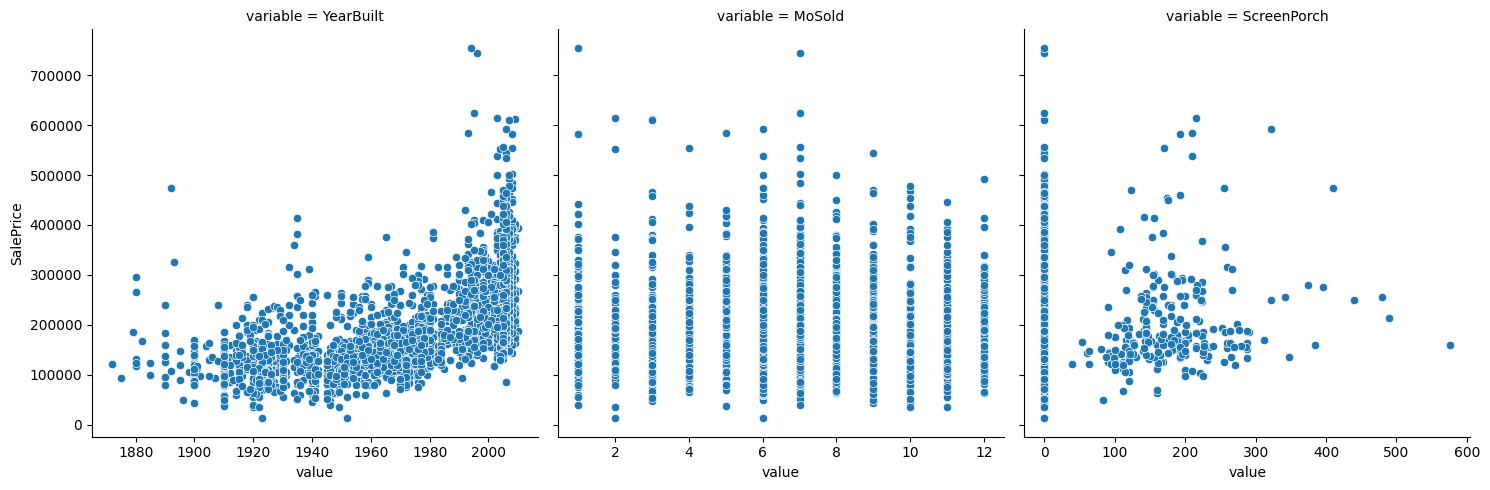

In [3]:
features = ["YearBuilt", "MoSold", "ScreenPorch"]
sns.relplot(
    x="value", y="SalePrice", col="variable", data=df.melt(id_vars="SalePrice", value_vars=features), facet_kws=dict(sharex=False),
);

<h3>1) Understand Mutual Information</h3>

Based on the plots, which feature do you think would have the highest mutual information with SalePrice?

Based on the plots, YearBuilt should have the highest MI score since knowing the year tends to constrain SalePrice to a smaller range of possible values. This is generally not the case for MoSold, however. Finally, since ScreenPorch is usually just one value, 0, on average it won't tell you much about SalePrice (though more than MoSold) .

The Ames dataset has seventy-eight features -- a lot to work with all at once! Fortunately, you can identify the features with the most potential.

Use the make_mi_scores function (introduced in the tutorial) to compute mutual information scores for the Ames features:

OverallQual     0.581262
Neighborhood    0.569813
GrLivArea       0.496909
YearBuilt       0.437939
GarageArea      0.415014
TotalBsmtSF     0.390280
GarageCars      0.381467
FirstFlrSF      0.368825
BsmtQual        0.364779
KitchenQual     0.326194
ExterQual       0.322390
YearRemodAdd    0.315402
MSSubClass      0.287131
GarageFinish    0.265440
FullBath        0.251693
Foundation      0.236115
LotFrontage     0.233334
GarageType      0.226117
FireplaceQu     0.221955
SecondFlrSF     0.200658
Name: MI Scores, dtype: float64
ExterCond           0.020934
KitchenAbvGr        0.017677
BsmtHalfBath        0.013719
LotConfig           0.013637
ScreenPorch         0.012981
PoolArea            0.012831
MiscVal             0.010997
LowQualFinSF        0.009328
Heating             0.007622
Functional          0.006380
MiscFeature         0.004322
Street              0.003381
Condition2          0.003176
RoofMatl            0.002620
PoolQC              0.001370
Utilities           0.000291
Thre

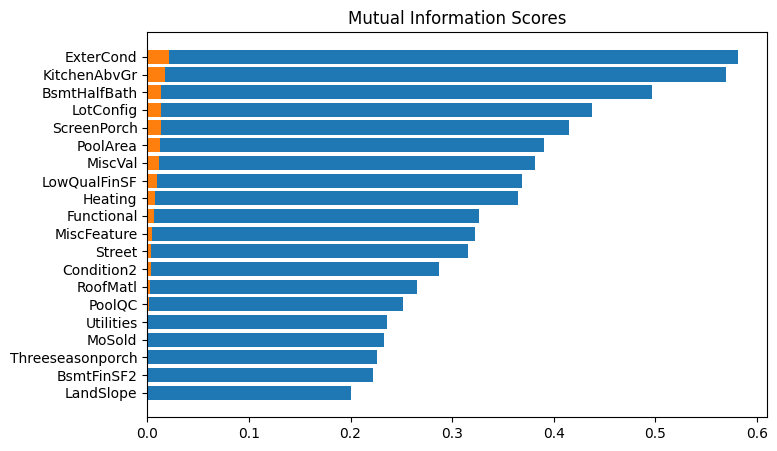

In [5]:
X = df.copy()
y = X.pop('SalePrice')

mi_scores = make_mi_scores(X, y)

print(mi_scores.head(20))
print(mi_scores.tail(20))

plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores.head(20))
plot_mi_scores(mi_scores.tail(20))

<h3>2) Examine MI Scores</h3>

Do the scores seem reasonable? Do the high scoring features represent things you'd think most people would value in a home? Do you notice any themes in what they describe? 